In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from sklearn import svm


## Table for data entries and abbreviations

#### Batting Data: G AB R H 2B 3B HR RBI BB IBB SO HBP SH SF XI ROE GDP SB CS AVG OBP SLG HAND

0: G: Games, total game played <br/>
1: AB: At bat, Total times at bat <br/>
2: R: Runs, total runs scored <br/>
3: H: Hits, total fair play hits <br/>
4: 2B: Double, reaching 2nd base from batting <br/>
5: 3B: Triple, reaching 3rd base from batting <br/>
6: HR: Home run, scoring straight from batting (includes in field home runs) <br/>
7: RBI: Runs batted in, total runs from this player's at bat <br/>
8: BB: Walks, total times walked (includes intentional walks) <br/>
9: IBB: Intentional Walk, intentionally walking batter to first base <br/>
10: SO: Strike out, total times struck out at base <br/>
11: HBP: Hit by pitch, total times <br/>
12: SH: Sacrifice bunt, bunt resulting in the batter being out but advances another runner <br/>
13: SF: Sacrifice fly, fly ball resulting in the batter being out but advances another runner <br/>
14: XI: ?, (almost all players have 0 for this statistic) <br/>
15: ROE: Reached on error, total times on base due to an error <br/>
16: GDP: Grounded into double play <br/>
17: SB: Stolen base, total bases stolen <br/>
18: CS: Caught stealing, Total times getting out when stealing.<br/>
19: AVG: Batting average, (total hits / total at bats) <br/>
20: OBP: On base percentage, (total times on base / total at bats) <br/>
21: SLG: Slugging percentage, bases per at bat ((1B + 2*2B + 3*3B + 4*HR) / AB) <br/>
22: HAND: Handedness, batting hand (1 = right, -1 = left) <br/>



#### Pitching Data: G GS CG SHO GF SV IP H BFP HR R ER BB IB SO SH SF WP HBP BK 2B 3B GDP ROE W L ERA RS PW HAND

0: G: Games played, total games played <br/>
1: GS: Games Started, threw the first pitch <br/>
2: CG: Complete game, pitched for the entire game <br/>
3: SHO: Shutout, pitches entire game without opposition scoring <br/>
4: GF: Games Finished, threw the last pitch (not counted if there was only 1 pitcher for the game) <br/>
5: SV: save, relief pitcher resulting in a win under certain conditions, https://www.mlb.com/glossary/standard-stats/save <br/>
6: IP: Innings pitched, total innings pitched (can be partial) <br/>
7: H: Hits, total hits allowed <br/>
8: BFP: Total batters face, total batters at plate when pitching <br/>
9: HR: Home runs allowed <br/>
10: R: Runs allowed?, total runs allowed <br/>
11: ER: Earned Run, total runs scored by the opposition due to the pitcher <br/>
12: BB: Walk, total walks <br/>
13: IB: Intentional walk? <br/>
14: SO: Strikeout, total batters struck out <br/>
15: SH: Sacrifice bunt, bunt resulting in the batter being out but advances another runner <br/>
16: SF: Sacrifice fly, fly ball resulting in the batter being out but advances another runner <br/>
17: WP: Wild pitches, pitch out of range for the catcher causing a runner to advance <br/>
18: HBP: Hit by pitch?, times batter is hit by a pitch <br/>
19: BK: Balk, number of illegal actions <br/>
20: 2B: Doubles allowed <br/>
21: 3B: Triples allowed <br/>
22: GDP: Grounded double plays? <br/>
23: ROE: Reached on error?, number of batters on base due to an error <br/>
24: W: Win, pitched while their team took the team and won the game <br/>
25: L: Loss, pitched while their team lost the lead and lost the game <br/>
26: ERA: Earned run average, (allowed runs * 9 / innings pitched ) <br/>
27: RS: Run support?, average opposition score (per game, not per inning) <br/>
28: PW: Total player rating, linear weighting of multiple statistics, https://en.wikipedia.org/wiki/Total_player_rating <br/>
29: HAND: Handedness, Pitching hand (1 = right, -1 = left) <br/>

In [2]:
def normalizePitcherData(data):
    for i in range(len(data)):
        #note normalizing here puts most values around the -1 to 1 range but many fields don't strictly follow this
        if(data[i][0] != 0):
            data[i][1:26] = data[i][1:26]/data[i][0] #what percentage of pitched games this happened / how many times per pitched game
        data[i][0] = data[i][0]/162 #what percentage of games the player pitches in
        #26,27,28,29 don't need to be changed
    return data
    
def normalizeBatterData(data):
    for i in range(len(data)):
        #note normalizing here puts most values around the -1 to 1 range but many fields don't strictly follow this
        if(data[i][1] != 0):
            data[i][2:19] = data[i][2:19]/data[i][1] #get average per at bat
        if(data[i][0] != 0):
            data[i][1] = data[i][1]/data[i][0] #avr. bats per batted game
        data[i][0] = data[i][0]/162 #shows what percent of games the player batts in
        #19,20,21,22 don't need to be changed
    return data

def getDataFromFile(fileName):
    fileData=np.loadtxt(fileName, delimiter=',') 
    [N,dim]=np.shape(fileData) #set up matrix from file
    
    dataX = np.zeros((N, dim))
    dataY = np.zeros((N))
    
    dataX = fileData[:, 0:dim - 1]
    dataY[:] = fileData[:, dim - 1]
    
    startIndex = 0
    #format of dataX:
    #home pitcher data (30 fields)
    dataX[:, startIndex:startIndex + 30] = normalizePitcherData(dataX[:, startIndex:startIndex + 30])
    startIndex = startIndex + 30
    #home batter 1 (23 fields)
    #home batter 2 (23 fields)
    #...
    #home batter 9 (23 fields)
    for i in range(9):
        dataX[:, startIndex:startIndex + 23] = normalizeBatterData(dataX[:, startIndex:startIndex + 23])
        startIndex = startIndex + 23
    
    #away pitcher data (30 fields)
    dataX[:, startIndex:startIndex + 30] = normalizePitcherData(dataX[:, startIndex:startIndex + 30])
    startIndex = startIndex + 30
    #away batter 1 (23 fields)
    #away batter 2 (23 fields)
    #...
    #away batter 9 (23 fields)
    for i in range(9):
        dataX[:, startIndex:startIndex + 23] = normalizeBatterData(dataX[:, startIndex:startIndex + 23])
        startIndex = startIndex + 23
    
    #for pitcher data: divide all fields by 162 to normalize
    return dataX, dataY
    
trainFileName = "C:\\Users\\Jesse\\Documents\\GitHub\\BaseballML\\ML Data\\train.txt"
valFileName = "C:\\Users\\Jesse\\Documents\\GitHub\\BaseballML\\ML Data\\val.txt"
testFileName = "C:\\Users\\Jesse\\Documents\\GitHub\\BaseballML\\ML Data\\test.txt"

trainX, trainY = getDataFromFile(trainFileName)
valX, valY = getDataFromFile(valFileName)
testX, testY = getDataFromFile(testFileName)#

print(np.shape(trainX))

(32555, 474)


In [ ]:
clf=svm.SVC(kernel='rbf', C=10e2)
clf.fit(trainX, trainY)
gtest=clf.predict(valX)
sv=clf.support_vectors_
Eout=np.mean(valY!=gtest)
print("Eout         : %.1f"% (Eout*100), "%")
print("SV  estimate : %.1f"%(np.sum(clf.n_support_)*100/(N-1)), "%")

In [ ]:

imageData = np.zeros((20,30))
imageData[0] = dataEntry[0:29]
for i in range(0,9):
    imageData[i+1][0:23] = dataEntry[30 + 23*i]
imageData[10] = dataEntry

Epoch 1/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6900 - accuracy: 0.5415 - val_loss: 0.6769 - val_accuracy: 0.5844
Epoch 2/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6793 - accuracy: 0.5713 - val_loss: 0.6785 - val_accuracy: 0.5719
Epoch 3/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6776 - accuracy: 0.5757 - val_loss: 0.6788 - val_accuracy: 0.5774
Epoch 4/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6751 - accuracy: 0.5787 - val_loss: 0.6710 - val_accuracy: 0.5879
Epoch 5/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6782 - accuracy: 0.5780 - val_loss: 0.6742 - val_accuracy: 0.5820
Epoch 6/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6753 - accuracy: 0.5815 - val_loss: 0.6698 - val_accuracy: 0.5926
Epoch 7/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6720 - accuracy: 0.5879 - val_loss: 0.6681 - val_ac

Epoch 57/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6425 - accuracy: 0.6195 - val_loss: 0.6831 - val_accuracy: 0.5864
Epoch 58/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6433 - accuracy: 0.6214 - val_loss: 0.6835 - val_accuracy: 0.5888
Epoch 59/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6440 - accuracy: 0.6169 - val_loss: 0.6982 - val_accuracy: 0.5809
Epoch 60/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6414 - accuracy: 0.6185 - val_loss: 0.6897 - val_accuracy: 0.5776
Epoch 61/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6388 - accuracy: 0.6266 - val_loss: 0.6953 - val_accuracy: 0.5880
Epoch 62/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6385 - accuracy: 0.6234 - val_loss: 0.6939 - val_accuracy: 0.5866
Epoch 63/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6368 - accuracy: 0.6276 - val_loss: 0.7043 -

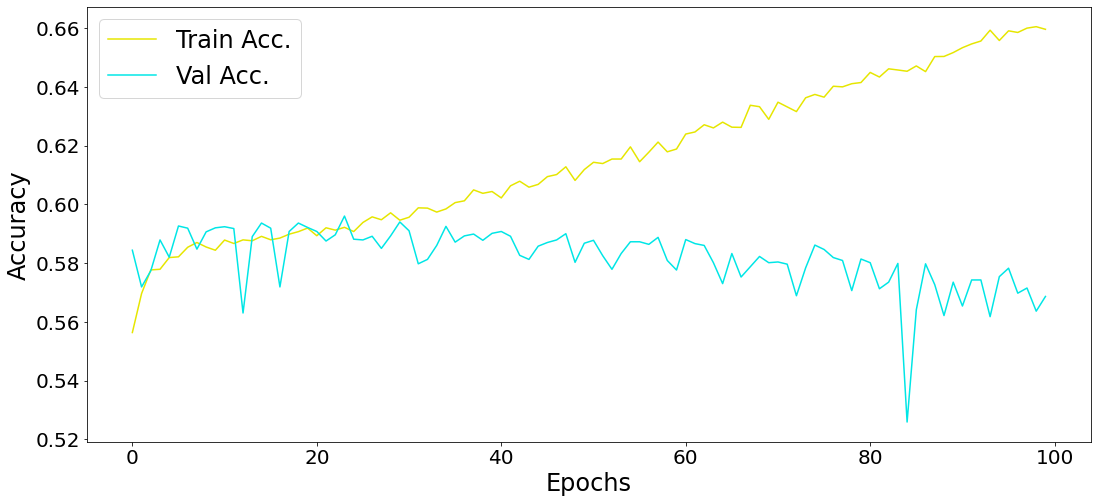

In [26]:




regParam = keras.regularizers.l2(.000001) #create regularization parameter
# ctrl + / to remove block comment
model = tf.keras.Sequential([
        keras.layers.Dense(units=np.shape(trainX)[1], activation='sigmoid', kernel_regularizer=regParam),
        keras.layers.Dense(units=100, activation='relu', kernel_regularizer=regParam),
        #keras.layers.Dropout(.02, input_shape=(100,)),
        keras.layers.Dense(units=100, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

historyData = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=100, verbose=1)
eIn = historyData.history["accuracy"]
eOut = historyData.history["val_accuracy"]

fig, ax = plt.subplots(figsize=(18,8))

ax.plot(eIn, color=(.9,.9,0), label="Train Acc.")
ax.plot(eOut, color=(0,.9,.9), label="Val Acc.")

ax.legend(fontsize=24)
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Accuracy", fontsize=24)

ax.tick_params(axis='both', labelsize=20)

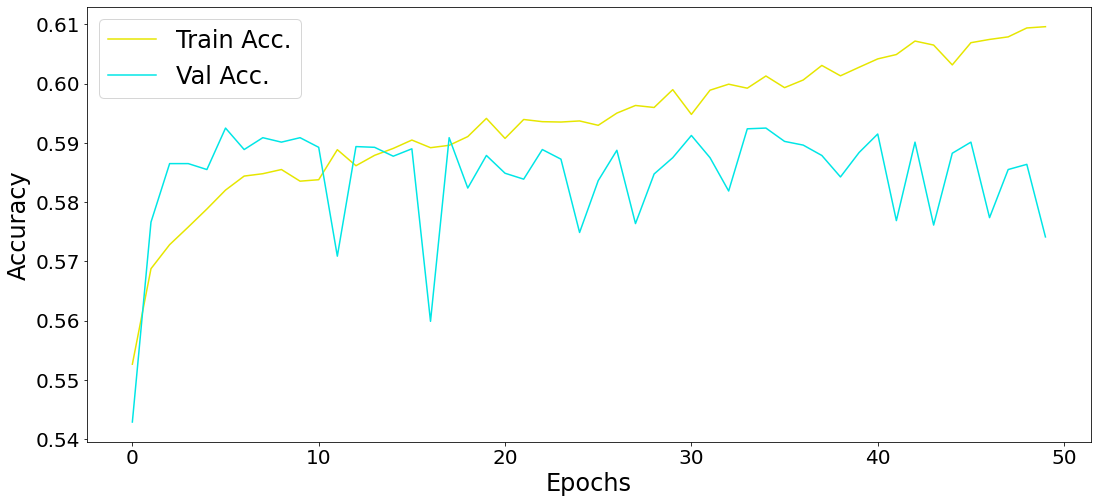

In [5]:




regParam = keras.regularizers.l2(.000001) #create regularization parameter
# ctrl + / to remove block comment
model = tf.keras.Sequential([
        keras.layers.Dense(units=np.shape(trainX)[1], activation='relu', kernel_regularizer=regParam),
    
       
        keras.layers.Dense(units=100, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=100, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

historyData = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=100, verbose=1)

Epoch 1/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6979 - accuracy: 0.5363 - val_loss: 0.6828 - val_accuracy: 0.5723
Epoch 2/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6809 - accuracy: 0.5641 - val_loss: 0.6742 - val_accuracy: 0.5831
Epoch 3/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6799 - accuracy: 0.5657 - val_loss: 0.6734 - val_accuracy: 0.5900
Epoch 4/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6765 - accuracy: 0.5741 - val_loss: 0.6749 - val_accuracy: 0.5820
Epoch 5/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6747 - accuracy: 0.5781 - val_loss: 0.6804 - val_accuracy: 0.5683
Epoch 6/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6732 - accuracy: 0.5857 - val_loss: 0.6697 - val_accuracy: 0.5876
Epoch 7/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6728 - accuracy: 0.5834 - val_loss: 0.6722 - val_ac

Epoch 57/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6447 - accuracy: 0.6115 - val_loss: 0.7075 - val_accuracy: 0.5835
Epoch 58/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6472 - accuracy: 0.6042 - val_loss: 0.6966 - val_accuracy: 0.5860
Epoch 59/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6465 - accuracy: 0.6067 - val_loss: 0.6810 - val_accuracy: 0.5841
Epoch 60/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6415 - accuracy: 0.6180 - val_loss: 0.6904 - val_accuracy: 0.5854
Epoch 61/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6433 - accuracy: 0.6112 - val_loss: 0.7095 - val_accuracy: 0.5863
Epoch 62/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6394 - accuracy: 0.6194 - val_loss: 0.7548 - val_accuracy: 0.5514
Epoch 63/100
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6472 - accuracy: 0.6070 - val_loss: 0.6883 -

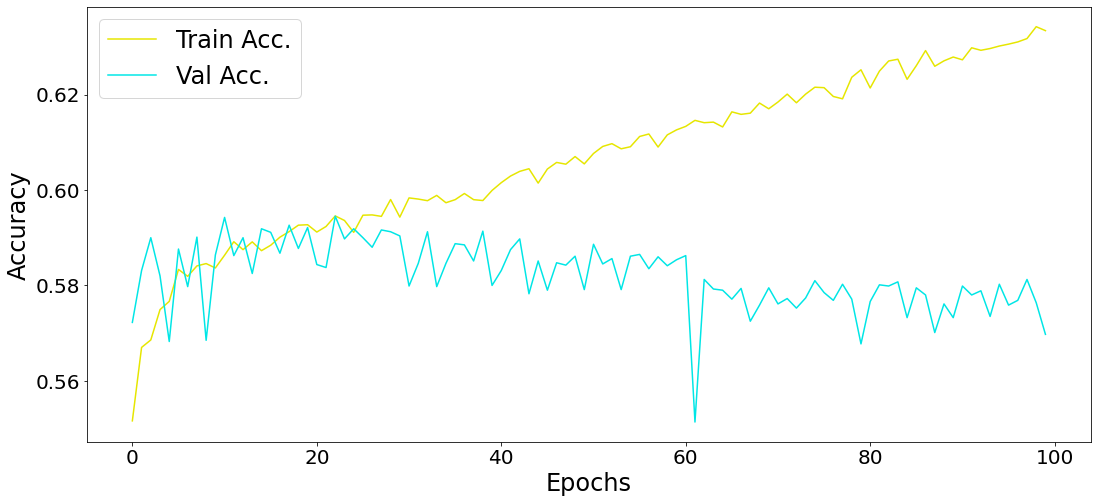

In [6]:
eIn = historyData.history["accuracy"]
eOut = historyData.history["val_accuracy"]

fig, ax = plt.subplots(figsize=(18,8))

ax.plot(eIn, color=(.9,.9,0), label="Train Acc.")
ax.plot(eOut, color=(0,.9,.9), label="Val Acc.")

ax.legend(fontsize=24)
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Accuracy", fontsize=24)

ax.tick_params(axis='both', labelsize=20)